In [3]:
%matplotlib inline

import pandas as pd
from utils import get_mongo_db
import itertools

Let's first get the MongoDB instance

In [4]:
db = get_mongo_db()

Connecting to MongoDB at localhost:27017...


Let's now compute the number of repositories per language (keeping in mind that the `repositories` collection contains both repositories owned by our Swiss users, but also any repository that they starred. It's thus a pretty big collection).

In [6]:
db.repositories.count()

121558

Let's first do the aggregation manually in Python:

In [7]:
repos = db.repositories.find({ 'language': { '$ne': None } }, { 'language': True })
repos.count()

112895

In [8]:
repos[0]

{'_id': 24002363, 'language': 'JavaScript'}

In [9]:
counts = {}
for repo in repos:
    if repo['language'] not in counts:
        counts[repo['language']] = 0
    counts[repo['language']] += 1

In [29]:
data = [{ 'language': lang, 'count': counts[lang] } for lang in counts]
df = pd.DataFrame(data).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,24930
Python,13263
PHP,9108
Ruby,8316
Java,8129
C,5472
C++,4877
Objective-C,4306
Shell,3666


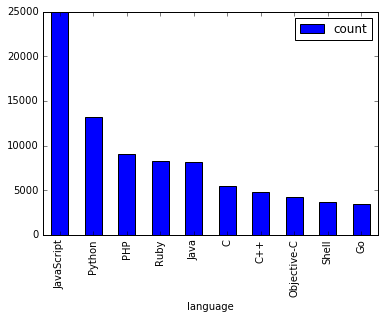

In [30]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')

Let's now use a potentially more efficient method, using MongoDB's aggregation framework:

In [31]:
from bson.son import SON

In [32]:
pipeline = [
    {
        '$match': { 'language': { '$ne': None } }
    },
    {
        '$group': {
            '_id': '$language',
            'count': { '$sum': 1 }
        }
    },
    {
        '$sort': SON([('count', -1), ('_id', -1)])
    }
]


data = list(db.repositories.aggregate(pipeline))

In [33]:
df = pd.DataFrame(data).rename(columns={ '_id': 'language' }).set_index('language')
df.sort_values(by='count', ascending=False)[0:10]

,count
language,
JavaScript,24930
Python,13263
PHP,9108
Ruby,8316
Java,8129
C,5472
C++,4877
Objective-C,4306
Shell,3666


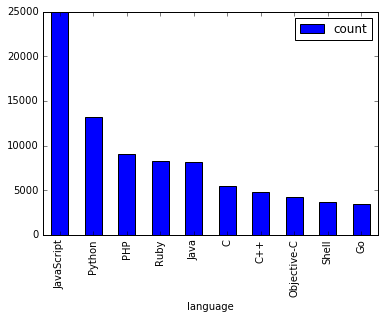

In [35]:
df.sort_values(by='count', ascending=False)[0:10].plot(kind='bar')